In [1]:
import keras
import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

#Importing the VAE and RNN.
import os
import sys
#Adding WorldModels path to pythonpath
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Using TensorFlow backend.


/home/kaiolae/code/word_models_keras_test/WorldModels


In [ ]:
#If we want to auto-load and compare all subfolders, we do this. otherwise, see below.
import fnmatch
UPPER_FOLDER = "../nov29_135_mixtures_early_stop_skip3/" #../"#"../nov16_rescaled_inputs/"#nov15_half_training_rate_skip5/"#"../nov14_half_training_rate_skip5/" # "../"
def get_all_models():
    all_models = {} #Dict of all models, with num mixtures as key
    for folder in os.listdir(UPPER_FOLDER):
        
        if fnmatch.fnmatch(folder, 'trained_sequential_rnn_*') :
            mixtures_start_index = folder.find('rnn_')+4
            mixtures_end_index = folder.find('mixtures')
            num_mixtures = int(folder[mixtures_start_index:mixtures_end_index])
            if num_mixtures in all_models.keys():
                all_models[num_mixtures].append(UPPER_FOLDER+folder)
            else:
                all_models[num_mixtures] = [UPPER_FOLDER+folder]
            
    return all_models
            
print(get_all_models())

In [2]:
import fnmatch
def get_histories(upper_folder, lower_folder_name=None):
    all_models = [] #Dict of all models, with num mixtures as key
    for folder in os.listdir(upper_folder):  
        if fnmatch.fnmatch(folder, lower_folder_name):
            history_file = upper_folder+folder+"/training_history.h5"
            if os.path.isfile(history_file):
                #Fails if the run ended early due to NaNs
                all_models.append(history_file)          
            else:
                print("Folder without history file: ", upper_folder+folder)
    return all_models
            

#Defining which folders to load.
folder_names_and_paths = {"bigbatch": "../dec14_bigbatch_1000epochs/",
                         "smallbatch": "../dec6_2000_episodes_gpu_both/"}

training_histories = {}
for key, val in folder_names_and_paths.items():
    histories = get_histories(val, "trained_sequential_rnn_5*")
    training_histories[key] = histories
    
print(training_histories)

Folder without history file:  ../dec6_2000_episodes_gpu_both/trained_sequential_rnn_5mixtures_run3
{'bigbatch': ['../dec14_bigbatch_1000epochs/trained_sequential_rnn_5mixtures_run2/training_history.h5', '../dec14_bigbatch_1000epochs/trained_sequential_rnn_5mixtures_run3/training_history.h5', '../dec14_bigbatch_1000epochs/trained_sequential_rnn_5mixtures_run5/training_history.h5', '../dec14_bigbatch_1000epochs/trained_sequential_rnn_5mixtures_run4/training_history.h5', '../dec14_bigbatch_1000epochs/trained_sequential_rnn_5mixtures_run1/training_history.h5'], 'smallbatch': ['../dec6_2000_episodes_gpu_both/trained_sequential_rnn_5mixtures_run2/training_history.h5', '../dec6_2000_episodes_gpu_both/trained_sequential_rnn_5mixtures_run8/training_history.h5', '../dec6_2000_episodes_gpu_both/trained_sequential_rnn_5mixtures_run9/training_history.h5', '../dec6_2000_episodes_gpu_both/trained_sequential_rnn_5mixtures_run7/training_history.h5', '../dec6_2000_episodes_gpu_both/trained_sequential_rn

In [4]:
#Note: with early stopping, the total number of epochs varies.
#How do we plot loss then?
import pickle
loss_summary = []
max_length = 0
for treatment_name, history_files in training_histories.items():
    for history_file in history_files:
        with open(history_file, 'rb') as file:
            content=pickle.load(file)
            content['treatment'] = treatment_name
            loss_summary.append(content)
            if len(content['loss']) > max_length:
                max_length = len(content['loss'])
#print(loss_summary)
import pandas as pd
l_frame = pd.DataFrame(loss_summary)
print("Any NaNs?")
print(l_frame.isnull().values.any())

Any NaNs?
False


In [5]:
#Adjusting the loss lists so all have same length. That way, we can
#Plot the variance between them.
#TODO Not sure what is the best method here. I will try to just 
#append final loss values to all to make them same length.
extended_loss_summary = []
for l in loss_summary:
    current_solution={}
    for key, val in l.items():
        if key=="num_mixtures":
            current_solution[key] = val
        else:
            extended_list = val
            while(len(extended_list) < max_length):
                extended_list.append(extended_list[-1])
            current_solution[key] = extended_list
    extended_loss_summary.append(current_solution)
print(extended_loss_summary)
loss_summary = extended_loss_summary
    

AttributeError: 'str' object has no attribute 'append'

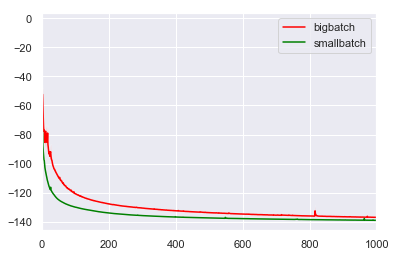

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.tsplot([l['loss'] for l in loss_summary if l['treatment'] == "bigbatch"], color="red", condition="bigbatch")
sns.tsplot([l['loss'] for l in loss_summary if l['treatment'] == "smallbatch"], color="green", condition="smallbatch")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.tsplot([l['loss'] for l in loss_summary if l['num_mixtures'] == 1], color="red", condition="1")
sns.tsplot([l['loss'] for l in loss_summary if l['num_mixtures'] == 3], color="green", condition="3")
sns.tsplot([l['loss'] for l in loss_summary if l['num_mixtures'] == 5], color="blue", condition="5")
#sns.tsplot([l['loss'] for l in loss_summary if l['num_mixtures'] == 8], color="black", condition="8")
#sns.tsplot([l['loss'] for l in loss_summary if l['num_mixtures'] == 16], color="pink", condition="16")
plt.legend()
# It looks like there are no confidence intervals here, but I wonder if they are just
# too narrow to be seen? Extremely stable behaviors.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.tsplot([l['val_loss'] for l in loss_summary if l['num_mixtures'] == 1], ci='sd', color="red", condition="1")
sns.tsplot([l['val_loss'] for l in loss_summary if l['num_mixtures'] == 3], color="green", condition="3")
sns.tsplot([l['val_loss'] for l in loss_summary if l['num_mixtures'] == 5], color="blue", condition="5")
#sns.tsplot([l['val_loss'] for l in loss_summary if l['num_mixtures'] == 8], color="black", condition="8")
#sns.tsplot([l['val_loss'] for l in loss_summary if l['num_mixtures'] == 16], color="pink", condition="16")
plt.legend()
# It looks like there are no confidence intervals here, but I wonder if they are just
# too narrow to be seen? Extremely stable behaviors.